In [1]:
# Total time spent on activities
# 10:20

#### Answers

In [2]:
# 2.c - Chose parquet files because found out it is optimized for big data. Never used it and wanted to give it a try.
# 3 - Last week between last 2 fridays of March from years 2019 and 2020
# 4 - CargoDetails, imo and destination
# 5 - Xangai port region
# 6 - Checked
# 7 - Checked
# 8 - I agree with the data presented for this vessel. It has just one contiguous event and just one value for timestamp, speedOverGround, Navigation Code and Navigation Description. Also, the Navigation Description is Unknown, which represents well the status.
# 9 and 10 - See graph
# 11 - checked
# 12 - checked
# 13 - checked

#### Importing libs

In [3]:
import pandas as pd
from glob import glob
import missingno
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

from sklearn.model_selection import train_test_split
import catboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

#### Loading Data and initial look

In [4]:
files_list = glob('../input/parquet/*')
files_list

['../input/parquet/part-00001-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00003-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00005-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00004-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00007-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00000-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00008-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00006-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00009-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet',
 '../input/parquet/part-00002-91b4ffd0-5234-4ade-9b7f-a8a66789a0a7-c000.snappy.parquet']

In [5]:
def ReadFile (file_path:str):
    return pd.read_parquet(file_path)

In [6]:
df = pd.concat(map(ReadFile, files_list))
df.reset_index(drop=True, inplace=True)

In [7]:
len(df)

3473877

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3473877 entries, 0 to 3473876
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   epochMillis     int64  
 1   mmsi            int64  
 2   position        object 
 3   navigation      object 
 4   olson_timezone  object 
 5   vesselDetails   object 
 6   port            object 
 7   imo             float64
 8   callSign        object 
 9   destination     object 
 10  cargoDetails    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 291.5+ MB


In [9]:
df.head(5)

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,cargoDetails
0,1553823987000,413359050,"{'latitude': 30.600624, 'longitude': 122.09645}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'XINHAIJIHEXIEHAO', 'typeName': 'Carg...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,BHV4,YANGSHAN,None
1,1553824444000,412751840,"{'latitude': 30.887007, 'longitude': 122.47231}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'CHUAN HAI', 'typeName': 'Cargo', 'ty...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,BKRP4,ZHOU SHAM,None
2,1553824606000,412379280,"{'latitude': 31.327448, 'longitude': 121.70429}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'CHANG JIANG KOU 01', 'typeName': 'Ot...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9564281.0,BSIK,SHANGHAI,None
3,1553824711000,373407000,"{'latitude': 31.369724, 'longitude': 121.591385}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SUNNY LOTUS', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9641156.0,3FYW7,SHA CN,"Carrying DG,HS or MP,IMO hazard or Pollutant C..."
4,1553824810000,412351040,"{'latitude': 31.36918, 'longitude': 121.50128}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'HANGJIEJUNBO10686', 'typeName': 'Unk...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,YYYY,NEW YORK,None


In [10]:
df['position'][0]

{'latitude': 30.600624, 'longitude': 122.09645}

In [11]:
df['navigation'][0]

{'navCode': 0,
 'navDesc': 'Under Way Using Engine',
 'courseOverGround': 287.3,
 'heading': 187.0,
 'rateOfTurn': 0.0,
 'speedOverGround': 4.7}

In [12]:
df['vesselDetails'][0]

{'name': 'XINHAIJIHEXIEHAO',
 'typeName': 'Cargo',
 'typeCode': 70,
 'draught': 3.0,
 'length': 100.0,
 'width': 18.0,
 'flagCode': 413,
 'flagCountry': 'China'}

In [13]:
df['port'][0]

{'unlocode': 'CNSHG',
 'name': 'SHANGHAI PT',
 'latitude': 31.334994,
 'longitude': 121.659069}

#### Looking for sparsity

<AxesSubplot:>

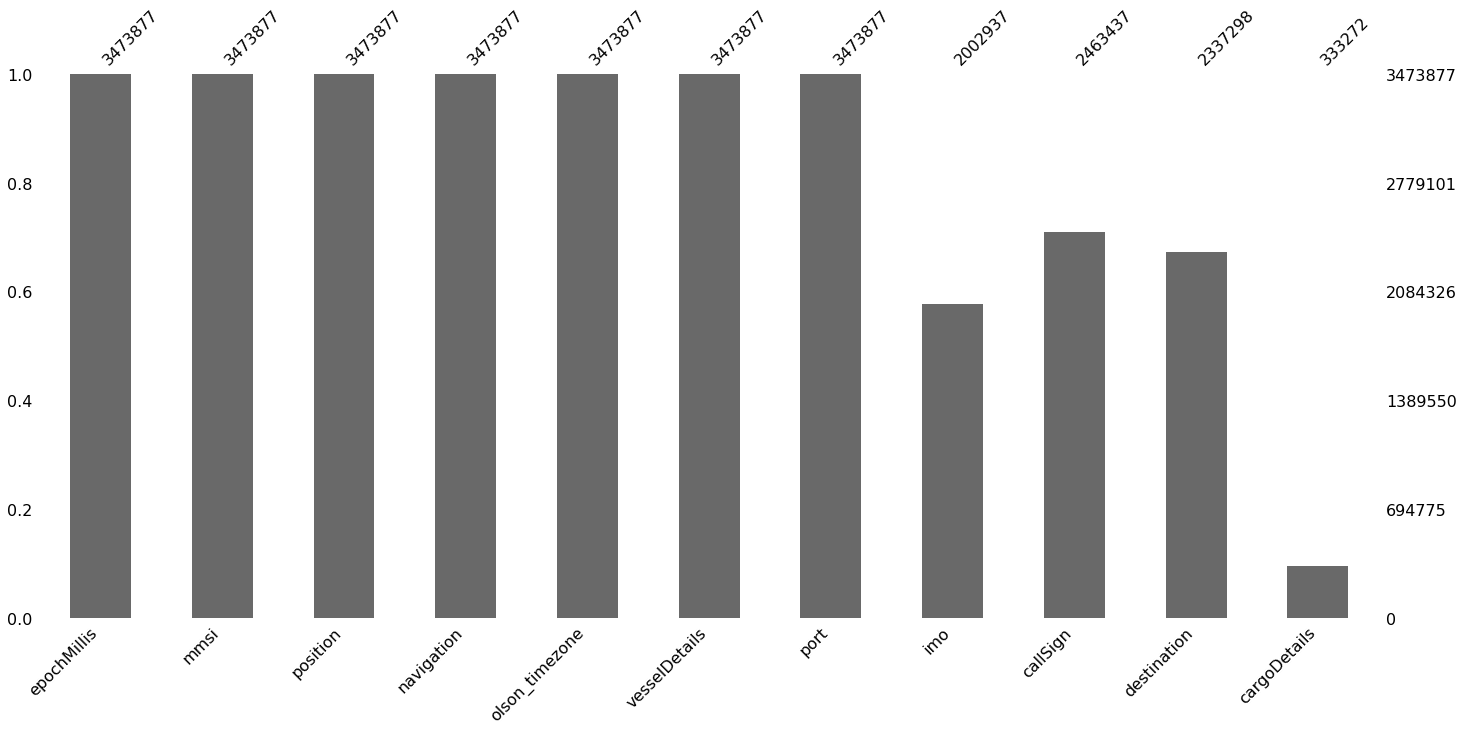

In [14]:
missingno.bar(df)

#### Sorting data

In [15]:
df_sorted = df.sort_values(['mmsi', 'epochMillis'], ascending=[True, True])
df_sorted.reset_index(drop=True, inplace=True)

In [16]:
df_sorted

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,cargoDetails
0,1584923314000,201006210,"{'latitude': 30.527903, 'longitude': 122.43617}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None
1,1584923974000,201006210,"{'latitude': 30.547867, 'longitude': 122.42847}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None
2,1584924714000,201006210,"{'latitude': 30.570444, 'longitude': 122.41924}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None
3,1584968514000,201006210,"{'latitude': 30.588017, 'longitude': 122.407776}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None
4,1584969774000,201006210,"{'latitude': 30.6248, 'longitude': 122.37332}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
3473872,1585117184000,701402207,"{'latitude': 30.714363, 'longitude': 122.80468}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None
3473873,1585127324000,701402207,"{'latitude': 30.707027, 'longitude': 122.807144}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None
3473874,1585128541000,701402207,"{'latitude': 30.662123, 'longitude': 122.78252}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None
3473875,1585129171000,701402207,"{'latitude': 30.640303, 'longitude': 122.76865}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None


#### Extracting date data

In [17]:
def TransformEpochmillisToDatetime (millis:int):
    seconds = millis / 1000.0
    return datetime.datetime.fromtimestamp(seconds).strftime('%Y-%m-%d %H:%M:%S')

def TransformDatetimeToDate (date):
    return date.split(' ')[0]

In [18]:
df_sorted['datetime']=df_sorted['epochMillis'].apply(lambda x: TransformEpochmillisToDatetime(x))

In [19]:
df_sorted['date']=df_sorted['datetime'].apply(lambda x: TransformDatetimeToDate(x))

In [20]:
df_sorted

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,cargoDetails,datetime,date
0,1584923314000,201006210,"{'latitude': 30.527903, 'longitude': 122.43617}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-22 21:28:34,2020-03-22
1,1584923974000,201006210,"{'latitude': 30.547867, 'longitude': 122.42847}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-22 21:39:34,2020-03-22
2,1584924714000,201006210,"{'latitude': 30.570444, 'longitude': 122.41924}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-22 21:51:54,2020-03-22
3,1584968514000,201006210,"{'latitude': 30.588017, 'longitude': 122.407776}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-23 10:01:54,2020-03-23
4,1584969774000,201006210,"{'latitude': 30.6248, 'longitude': 122.37332}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-23 10:22:54,2020-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473872,1585117184000,701402207,"{'latitude': 30.714363, 'longitude': 122.80468}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None,2020-03-25 03:19:44,2020-03-25
3473873,1585127324000,701402207,"{'latitude': 30.707027, 'longitude': 122.807144}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None,2020-03-25 06:08:44,2020-03-25
3473874,1585128541000,701402207,"{'latitude': 30.662123, 'longitude': 122.78252}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None,2020-03-25 06:29:01,2020-03-25
3473875,1585129171000,701402207,"{'latitude': 30.640303, 'longitude': 122.76865}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,None,2020-03-25 06:39:31,2020-03-25


#### Looking for time period

In [21]:
df_sorted['datetime'].describe()

count                 3473877
unique                1085442
top       2019-03-28 11:31:31
freq                       34
Name: datetime, dtype: object

In [22]:
df_sorted['date'].describe()

count        3473877
unique            16
top       2019-03-28
freq          272105
Name: date, dtype: object

In [23]:
count_datetime = df_sorted['datetime'].value_counts()
count_datetime

2019-03-28 11:31:31    34
2019-03-28 11:31:23    29
2019-03-28 11:31:26    26
2019-03-28 11:31:27    23
2020-03-22 00:31:28    22
                       ..
2019-03-29 00:08:55     1
2019-03-25 03:03:29     1
2019-03-29 10:05:37     1
2019-03-29 12:21:43     1
2019-03-28 00:14:44     1
Name: datetime, Length: 1085442, dtype: int64

In [24]:
count_date = df_sorted['date'].value_counts()
count_date

2019-03-28    272105
2019-03-27    264178
2019-03-26    257478
2020-03-21    245501
2020-03-26    244693
2019-03-25    243305
2019-03-29    242145
2020-03-22    240498
2020-03-25    238770
2020-03-23    238510
2019-03-23    237432
2019-03-24    234030
2020-03-24    233277
2020-03-27    205767
2020-03-20     39032
2019-03-22     37156
Name: date, dtype: int64

In [25]:
df_count_date = pd.DataFrame(count_date).reset_index().sort_values('index')
df_count_date.rename(columns={'index':'date','date':'frequency'}, inplace=True)
df_count_date

,date,frequency
15,2019-03-22,37156
10,2019-03-23,237432
11,2019-03-24,234030
5,2019-03-25,243305
2,2019-03-26,257478
1,2019-03-27,264178
0,2019-03-28,272105
6,2019-03-29,242145
14,2020-03-20,39032
3,2020-03-21,245501


<AxesSubplot:title={'center':'Dates and their frequency'}, xlabel='date', ylabel='frequency'>

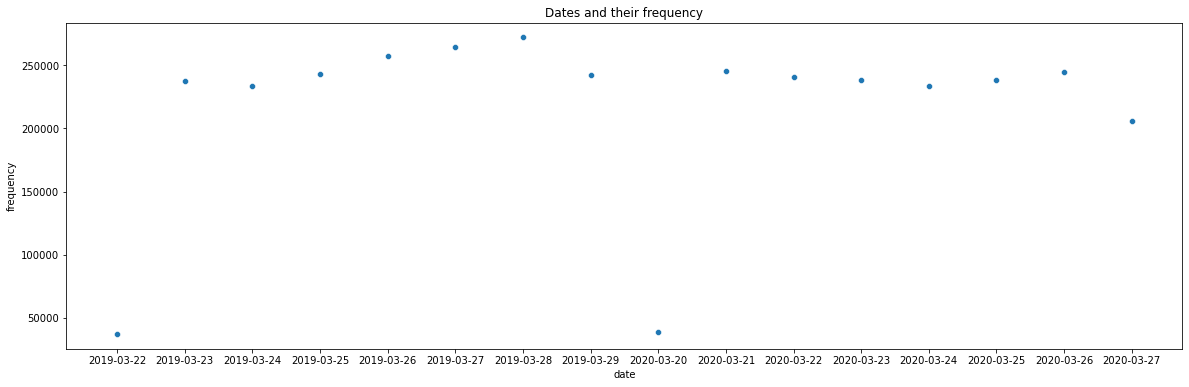

In [26]:
fig = plt.subplots(figsize = (20, 6))
plt.title("Dates and their frequency")
sns.scatterplot(x='date', y='frequency', data=df_count_date)

#### Extracting location data

In [27]:
df_sorted['vessel_latitude'] = df_sorted['position'].apply(lambda x: x['latitude'])
df_sorted['vessel_longitude'] = df_sorted['position'].apply(lambda x: x['longitude'])

In [28]:
df_sorted['port_latitude'] = df_sorted['port'].apply(lambda x: x['latitude'])
df_sorted['port_longitude'] = df_sorted['port'].apply(lambda x: x['longitude'])

In [29]:
df_sorted.head(2)

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,cargoDetails,datetime,date,vessel_latitude,vessel_longitude,port_latitude,port_longitude
0,1584923314000,201006210,"{'latitude': 30.527903, 'longitude': 122.43617}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-22 21:28:34,2020-03-22,30.527903,122.43617,31.334994,121.659069
1,1584923974000,201006210,"{'latitude': 30.547867, 'longitude': 122.42847}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None,2020-03-22 21:39:34,2020-03-22,30.547867,122.42847,31.334994,121.659069


#### Location Analysis

<AxesSubplot:>

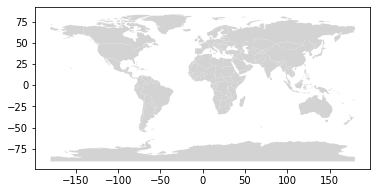

In [30]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries.plot(color='lightgrey')

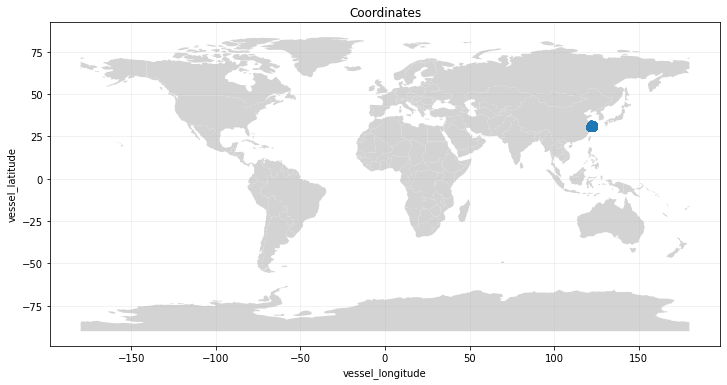

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

countries.plot(color='lightgrey', ax=ax)

df_sorted.plot(x='vessel_longitude', 
               y='vessel_latitude', 
               kind='scatter',
               title='Coordinates', 
               ax=ax
               )

ax.grid(visible=True, alpha=0.2)

plt.show()

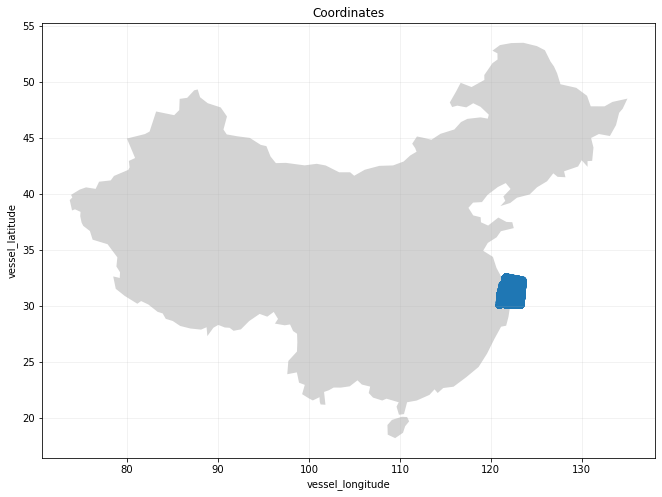

In [32]:
fig, ax = plt.subplots(figsize=(12,8))

countries[countries['name']=='China'].plot(color='lightgrey', ax=ax)

df_sorted.plot(x='vessel_longitude', 
               y='vessel_latitude', 
               kind='scatter',
               title='Coordinates', 
               ax=ax
               )

ax.grid(visible=True, alpha=0.2)

plt.show()

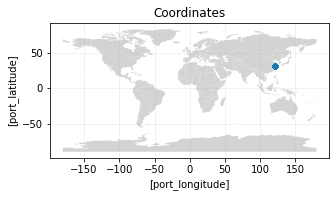

In [33]:
fig, ax = plt.subplots(figsize=(5,3))

countries.plot(color='lightgrey', ax=ax)

df_sorted.plot(x=['port_longitude'], 
               y=['port_latitude'], 
               kind='scatter',
               title='Coordinates', 
               ax=ax
               )

ax.grid(visible=True, alpha=0.2)

plt.show()

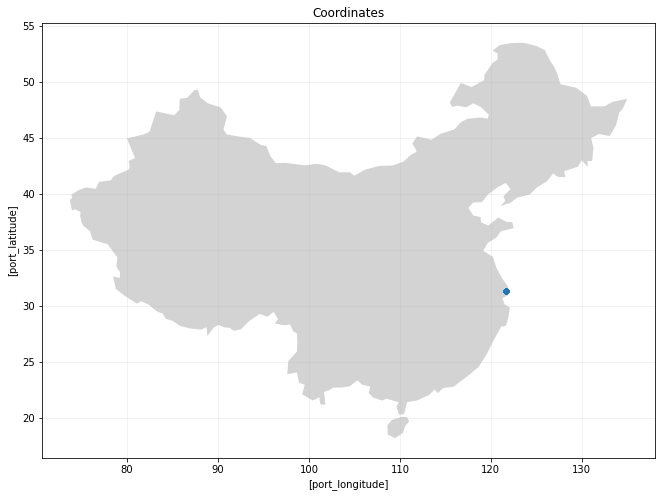

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

countries[countries['name']=='China'].plot(color='lightgrey', ax=ax)

df_sorted.plot(x=['port_longitude'], 
               y=['port_latitude'], 
               kind='scatter',
               title='Coordinates', 
               ax=ax
               )

ax.grid(visible=True, alpha=0.2)

plt.show()

In [35]:
df_sorted['port_latitude'].value_counts()

31.334994    3473877
Name: port_latitude, dtype: int64

In [36]:
df_sorted['port_longitude'].value_counts()

121.659069    3473877
Name: port_longitude, dtype: int64

In [37]:
mapplot = countries[countries['name']=='China'].explore()
x1,y1 = 121.659069, 31.334994
folium.Marker(location=[y1,x1],
              popup='port',
              fill_color='#ff0000',
              radius=8
              ).add_to(mapplot)
zoom_factor = 0.2
mapplot.fit_bounds([[y1+zoom_factor,x1+zoom_factor],[y1-zoom_factor,x1-zoom_factor]])
mapplot

#### Navigation data

In [38]:
df_sorted['navigation'][1360752]

{'navCode': 0,
 'navDesc': 'Under Way Using Engine',
 'courseOverGround': 306.5,
 'heading': 113.0,
 'rateOfTurn': 0.0,
 'speedOverGround': 5.7}

In [39]:
df_sorted['navCode'] = df_sorted['navigation'].apply(lambda x: x['navCode'])
df_sorted['navDesc'] = df_sorted['navigation'].apply(lambda x: x['navDesc'])
df_sorted['speedOverGround'] = df_sorted['navigation'].apply(lambda x: x['speedOverGround'])
df_sorted['courseOverGround'] = df_sorted['navigation'].apply(lambda x: x['courseOverGround'])


In [40]:
df_sorted

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,datetime,date,vessel_latitude,vessel_longitude,port_latitude,port_longitude,navCode,navDesc,speedOverGround,courseOverGround
0,1584923314000,201006210,"{'latitude': 30.527903, 'longitude': 122.43617}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-22 21:28:34,2020-03-22,30.527903,122.436170,31.334994,121.659069,0,Under Way Using Engine,6.4,349.0
1,1584923974000,201006210,"{'latitude': 30.547867, 'longitude': 122.42847}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-22 21:39:34,2020-03-22,30.547867,122.428470,31.334994,121.659069,0,Under Way Using Engine,7.0,340.7
2,1584924714000,201006210,"{'latitude': 30.570444, 'longitude': 122.41924}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-22 21:51:54,2020-03-22,30.570444,122.419240,31.334994,121.659069,0,Under Way Using Engine,7.0,342.6
3,1584968514000,201006210,"{'latitude': 30.588017, 'longitude': 122.407776}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-23 10:01:54,2020-03-23,30.588017,122.407776,31.334994,121.659069,0,Under Way Using Engine,7.4,322.1
4,1584969774000,201006210,"{'latitude': 30.6248, 'longitude': 122.37332}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-23 10:22:54,2020-03-23,30.624800,122.373320,31.334994,121.659069,0,Under Way Using Engine,8.9,320.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473872,1585117184000,701402207,"{'latitude': 30.714363, 'longitude': 122.80468}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25 03:19:44,2020-03-25,30.714363,122.804680,31.334994,121.659069,16,Unknown,9.2,131.7
3473873,1585127324000,701402207,"{'latitude': 30.707027, 'longitude': 122.807144}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25 06:08:44,2020-03-25,30.707027,122.807144,31.334994,121.659069,16,Unknown,10.0,201.0
3473874,1585128541000,701402207,"{'latitude': 30.662123, 'longitude': 122.78252}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25 06:29:01,2020-03-25,30.662123,122.782520,31.334994,121.659069,16,Unknown,8.7,212.7
3473875,1585129171000,701402207,"{'latitude': 30.640303, 'longitude': 122.76865}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25 06:39:31,2020-03-25,30.640303,122.768650,31.334994,121.659069,16,Unknown,8.6,204.1


In [41]:
navCode= dict(df_sorted['navCode'].value_counts())
df_navCode = pd.DataFrame(navCode.items(), columns=['navCode', 'frequency'])
df_navCode

,navCode,frequency
0,16,1357985
1,0,1063676
2,5,554133
3,1,426433
4,15,29330
5,8,24889
6,3,8237
7,2,3471
8,4,1483
9,9,1359


In [42]:
navDesc= dict(df_sorted['navDesc'].value_counts())
df_navDesc = pd.DataFrame(navDesc.items(), columns=['navDesc', 'frequency'])
df_navDesc

,navDesc,frequency
0,Unknown,1357985
1,Under Way Using Engine,1063676
2,Moored,554133
3,At Anchor,426433
4,Not Defined,29330
5,Underway Sailing,24889
6,Restricted Manoeuvrability,8237
7,Not Under Command,3471
8,Reserved For Future Use,2159
9,Constrained By Her Draught,1483


In [43]:
df_sorted['speedOverGround'].value_counts()

0.0     1529480
0.1      390151
0.2      111928
0.3       51888
0.4       28650
         ...   
47.5          1
85.4          1
89.9          1
75.2          1
64.0          1
Name: speedOverGround, Length: 575, dtype: int64

In [44]:
df_sorted['courseOverGround'].value_counts()

0.0      509197
3.1        3949
180.0      3237
181.0      2965
179.0      2916
          ...  
407.0         1
375.3         1
364.7         1
404.6         1
360.0         1
Name: courseOverGround, Length: 3655, dtype: int64

#### Specific mmsi data

In [45]:
df_specific_mmsi = df_sorted[df_sorted['mmsi']==205792000]
df_specific_mmsi

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,datetime,date,vessel_latitude,vessel_longitude,port_latitude,port_longitude,navCode,navDesc,speedOverGround,courseOverGround
3722,1584948218000,205792000,"{'latitude': 31.296667, 'longitude': 122.734}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:23:38,2020-03-23,31.296667,122.734000,31.334994,121.659069,5,Moored,12.4,242.2
3723,1584948839000,205792000,"{'latitude': 31.280333, 'longitude': 122.70216}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:33:59,2020-03-23,31.280333,122.702160,31.334994,121.659069,5,Moored,9.8,241.0
3724,1584949458000,205792000,"{'latitude': 31.269833, 'longitude': 122.683}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:44:18,2020-03-23,31.269833,122.683000,31.334994,121.659069,5,Moored,3.9,254.4
3725,1584950312000,205792000,"{'latitude': 31.265375, 'longitude': 122.67103}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:58:32,2020-03-23,31.265375,122.671030,31.334994,121.659069,5,Moored,1.1,162.0
3726,1584951571000,205792000,"{'latitude': 31.263, 'longitude': 122.67067}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 05:19:31,2020-03-23,31.263000,122.670670,31.334994,121.659069,1,At Anchor,0.0,323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,1585126972000,205792000,"{'latitude': 31.0945, 'longitude': 122.51033}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:02:52,2020-03-25,31.094500,122.510330,31.334994,121.659069,0,Under Way Using Engine,14.5,106.1
3902,1585127584000,205792000,"{'latitude': 31.087833, 'longitude': 122.5585}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:13:04,2020-03-25,31.087833,122.558500,31.334994,121.659069,0,Under Way Using Engine,15.5,87.7
3903,1585127668000,205792000,"{'latitude': 31.0885, 'longitude': 122.5655}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:14:28,2020-03-25,31.088500,122.565500,31.334994,121.659069,0,Under Way Using Engine,15.8,87.3
3904,1585129042000,205792000,"{'latitude': 31.081333, 'longitude': 122.691666}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:37:22,2020-03-25,31.081333,122.691666,31.334994,121.659069,0,Under Way Using Engine,17.9,95.4


In [46]:
df_specific_mmsi.reset_index(drop=True, inplace=True)

In [47]:
top5navCode = list(df_navCode.head(5)['navCode'])
top5navCode

[16, 0, 5, 1, 15]

In [48]:
df_specific_mmsi['navCode'].value_counts()

0    80
5    56
1    48
Name: navCode, dtype: int64

In [49]:
df_specific_mmsi[df_specific_mmsi['navCode'].isin(top5navCode)]

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,datetime,date,vessel_latitude,vessel_longitude,port_latitude,port_longitude,navCode,navDesc,speedOverGround,courseOverGround
0,1584948218000,205792000,"{'latitude': 31.296667, 'longitude': 122.734}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:23:38,2020-03-23,31.296667,122.734000,31.334994,121.659069,5,Moored,12.4,242.2
1,1584948839000,205792000,"{'latitude': 31.280333, 'longitude': 122.70216}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:33:59,2020-03-23,31.280333,122.702160,31.334994,121.659069,5,Moored,9.8,241.0
2,1584949458000,205792000,"{'latitude': 31.269833, 'longitude': 122.683}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:44:18,2020-03-23,31.269833,122.683000,31.334994,121.659069,5,Moored,3.9,254.4
3,1584950312000,205792000,"{'latitude': 31.265375, 'longitude': 122.67103}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 04:58:32,2020-03-23,31.265375,122.671030,31.334994,121.659069,5,Moored,1.1,162.0
4,1584951571000,205792000,"{'latitude': 31.263, 'longitude': 122.67067}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,2020-03-23 05:19:31,2020-03-23,31.263000,122.670670,31.334994,121.659069,1,At Anchor,0.0,323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1585126972000,205792000,"{'latitude': 31.0945, 'longitude': 122.51033}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:02:52,2020-03-25,31.094500,122.510330,31.334994,121.659069,0,Under Way Using Engine,14.5,106.1
180,1585127584000,205792000,"{'latitude': 31.087833, 'longitude': 122.5585}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:13:04,2020-03-25,31.087833,122.558500,31.334994,121.659069,0,Under Way Using Engine,15.5,87.7
181,1585127668000,205792000,"{'latitude': 31.0885, 'longitude': 122.5655}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:14:28,2020-03-25,31.088500,122.565500,31.334994,121.659069,0,Under Way Using Engine,15.8,87.3
182,1585129042000,205792000,"{'latitude': 31.081333, 'longitude': 122.691666}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,2020-03-25 06:37:22,2020-03-25,31.081333,122.691666,31.334994,121.659069,0,Under Way Using Engine,17.9,95.4


In [50]:
df_specific_mmsi['series_number']=-1

series_number = 0
initial_navCode = 99999

for index, row in df_specific_mmsi.iterrows():
    if row['navCode'] != initial_navCode: 
        initial_navCode = row['navCode']
        series_number+=1
        df_specific_mmsi.loc[index,'series_number']=series_number
    else:
        df_specific_mmsi.loc[index,'series_number']=series_number

/tmp/ipykernel_2843174/1441155960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_mmsi['series_number']=-1
/home/pedro/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [51]:
df_specific_mmsi['final_state_latitude']=0
df_specific_mmsi['final_state_longitude']=0
df_specific_mmsi['final_state_timestamp']=0
df_specific_mmsi['final_state_speedOverGround_mean']=0
df_specific_mmsi['lead_time']=0

for series_number in list(df_specific_mmsi['series_number'].unique()):
    for index, row in df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iterrows():
        df_specific_mmsi.loc[index,'final_state_speedOverGround_mean']=df_specific_mmsi[df_specific_mmsi['series_number']==series_number]['speedOverGround'].mean()
        df_specific_mmsi.loc[index,'final_state_latitude']=df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[-1]['vessel_latitude']
        df_specific_mmsi.loc[index,'final_state_longitude']=df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[-1]['vessel_longitude']
        first_timestamp = df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[0]['epochMillis']
        last_timestamp = df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[-1]['epochMillis']
        df_specific_mmsi.loc[index,'final_state_timestamp']=last_timestamp
        df_specific_mmsi.loc[index,'lead_time']=last_timestamp-first_timestamp

/tmp/ipykernel_2843174/2864838784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_mmsi['final_state_latitude']=0
/tmp/ipykernel_2843174/2864838784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_mmsi['final_state_longitude']=0
/tmp/ipykernel_2843174/2864838784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [52]:
# 205792000
df_specific_mmsi

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,navCode,navDesc,speedOverGround,courseOverGround,series_number,final_state_latitude,final_state_longitude,final_state_timestamp,final_state_speedOverGround_mean,lead_time
0,1584948218000,205792000,"{'latitude': 31.296667, 'longitude': 122.734}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,5,Moored,12.4,242.2,1,31.265375,122.67103,1584950312000,6.800000,2094000
1,1584948839000,205792000,"{'latitude': 31.280333, 'longitude': 122.70216}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,5,Moored,9.8,241.0,1,31.265375,122.67103,1584950312000,6.800000,2094000
2,1584949458000,205792000,"{'latitude': 31.269833, 'longitude': 122.683}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,5,Moored,3.9,254.4,1,31.265375,122.67103,1584950312000,6.800000,2094000
3,1584950312000,205792000,"{'latitude': 31.265375, 'longitude': 122.67103}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,5,Moored,1.1,162.0,1,31.265375,122.67103,1584950312000,6.800000,2094000
4,1584951571000,205792000,"{'latitude': 31.263, 'longitude': 122.67067}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNSHA,...,1,At Anchor,0.0,323.0,2,31.264334,122.66950,1585000171000,0.079167,48600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1585126972000,205792000,"{'latitude': 31.0945, 'longitude': 122.51033}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,0,Under Way Using Engine,14.5,106.1,5,31.074333,122.77600,1585129888000,11.048485,21002000
180,1585127584000,205792000,"{'latitude': 31.087833, 'longitude': 122.5585}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,0,Under Way Using Engine,15.5,87.7,5,31.074333,122.77600,1585129888000,11.048485,21002000
181,1585127668000,205792000,"{'latitude': 31.0885, 'longitude': 122.5655}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,0,Under Way Using Engine,15.8,87.3,5,31.074333,122.77600,1585129888000,11.048485,21002000
182,1585129042000,205792000,"{'latitude': 31.081333, 'longitude': 122.691666}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'TOUCAN HUNTER', 'typeName': 'Cargo',...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9400198.0,ONKM,CNYTN,...,0,Under Way Using Engine,17.9,95.4,5,31.074333,122.77600,1585129888000,11.048485,21002000


#### Creating Report Function to use with any mmsi

In [53]:
def CreateReportMMSI (mmsi:int):
    df_specific_mmsi = df_sorted[df_sorted['mmsi']==mmsi]
    df_specific_mmsi.reset_index(drop=True, inplace=True)
    top5navCode = list(df_navCode.head(5)['navCode'])
    df_specific_mmsi[df_specific_mmsi['navCode'].isin(top5navCode)]

    df_specific_mmsi['series_number']=-1

    series_number = 0
    initial_navCode = 99999

    for index, row in df_specific_mmsi.iterrows():
        if row['navCode'] != initial_navCode: 
            initial_navCode = row['navCode']
            series_number+=1
            df_specific_mmsi.loc[index,'series_number']=series_number
        else:
            df_specific_mmsi.loc[index,'series_number']=series_number
            
    df_specific_mmsi['final_state_latitude']=0
    df_specific_mmsi['final_state_longitude']=0
    df_specific_mmsi['final_state_timestamp']=0
    df_specific_mmsi['final_state_speedOverGround_mean']=0
    df_specific_mmsi['lead_time']=0

    for series_number in list(df_specific_mmsi['series_number'].unique()):
        for index, row in df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iterrows():
            df_specific_mmsi.loc[index,'final_state_speedOverGround_mean']=df_specific_mmsi[df_specific_mmsi['series_number']==series_number]['speedOverGround'].mean()
            df_specific_mmsi.loc[index,'final_state_latitude']=df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[-1]['vessel_latitude']
            df_specific_mmsi.loc[index,'final_state_longitude']=df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[-1]['vessel_longitude']
            first_timestamp = df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[0]['epochMillis']
            last_timestamp = df_specific_mmsi[df_specific_mmsi['series_number']==series_number].iloc[-1]['epochMillis']
            df_specific_mmsi.loc[index,'final_state_timestamp']=last_timestamp
            df_specific_mmsi.loc[index,'lead_time']=last_timestamp-first_timestamp
            
    return df_specific_mmsi
    

In [54]:
df_specific_mmsi2 = CreateReportMMSI(413970021)
df_specific_mmsi2

/tmp/ipykernel_2843174/3775842688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_mmsi['series_number']=-1
/home/pedro/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_2843174/3775842688.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,navCode,navDesc,speedOverGround,courseOverGround,series_number,final_state_latitude,final_state_longitude,final_state_timestamp,final_state_speedOverGround_mean,lead_time
0,1553298594000,413970021,"{'latitude': 31.326342, 'longitude': 121.55458}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,135.5,1,31.683237,121.19696,1553890569000,0.454707,591975000
1,1553299314000,413970021,"{'latitude': 31.32633, 'longitude': 121.55458}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,135.5,1,31.683237,121.19696,1553890569000,0.454707,591975000
2,1553299809000,413970021,"{'latitude': 31.326334, 'longitude': 121.554596}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,174.9,1,31.683237,121.19696,1553890569000,0.454707,591975000
3,1553300397000,413970021,"{'latitude': 31.326323, 'longitude': 121.55457}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,135.5,1,31.683237,121.19696,1553890569000,0.454707,591975000
4,1553300534000,413970021,"{'latitude': 31.326345, 'longitude': 121.55454}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,108.3,1,31.683237,121.19696,1553890569000,0.454707,591975000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1553877349000,413970021,"{'latitude': 31.68268, 'longitude': 121.19713}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,212.6,1,31.683237,121.19696,1553890569000,0.454707,591975000
389,1553880980000,413970021,"{'latitude': 31.682528, 'longitude': 121.19715}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,197.9,1,31.683237,121.19696,1553890569000,0.454707,591975000
390,1553885878000,413970021,"{'latitude': 31.682493, 'longitude': 121.1971}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,91.8,1,31.683237,121.19696,1553890569000,0.454707,591975000
391,1553889849000,413970021,"{'latitude': 31.683004, 'longitude': 121.197075}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XIANG HAO 08', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",2112.0,TXYR0,000,...,16,Unknown,0.0,251.8,1,31.683237,121.19696,1553890569000,0.454707,591975000


In [55]:
df_specific_mmsi2['navCode'].unique()

array([16])

In [56]:
df_specific_mmsi2['navDesc'].unique()

array(['Unknown'], dtype=object)

In [57]:
df_specific_mmsi2['series_number'].unique()

array([1])

In [58]:
df_specific_mmsi2['final_state_timestamp'].unique()

array([1553890569000])

#### Analysis per period

In [59]:
df_sorted['year'] = df_sorted['datetime'].apply(lambda x: int(x.split('-')[0]))
df_sorted

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,date,vessel_latitude,vessel_longitude,port_latitude,port_longitude,navCode,navDesc,speedOverGround,courseOverGround,year
0,1584923314000,201006210,"{'latitude': 30.527903, 'longitude': 122.43617}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-22,30.527903,122.436170,31.334994,121.659069,0,Under Way Using Engine,6.4,349.0,2020
1,1584923974000,201006210,"{'latitude': 30.547867, 'longitude': 122.42847}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-22,30.547867,122.428470,31.334994,121.659069,0,Under Way Using Engine,7.0,340.7,2020
2,1584924714000,201006210,"{'latitude': 30.570444, 'longitude': 122.41924}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-22,30.570444,122.419240,31.334994,121.659069,0,Under Way Using Engine,7.0,342.6,2020
3,1584968514000,201006210,"{'latitude': 30.588017, 'longitude': 122.407776}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-23,30.588017,122.407776,31.334994,121.659069,0,Under Way Using Engine,7.4,322.1,2020
4,1584969774000,201006210,"{'latitude': 30.6248, 'longitude': 122.37332}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,...,2020-03-23,30.624800,122.373320,31.334994,121.659069,0,Under Way Using Engine,8.9,320.1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473872,1585117184000,701402207,"{'latitude': 30.714363, 'longitude': 122.80468}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25,30.714363,122.804680,31.334994,121.659069,16,Unknown,9.2,131.7,2020
3473873,1585127324000,701402207,"{'latitude': 30.707027, 'longitude': 122.807144}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25,30.707027,122.807144,31.334994,121.659069,16,Unknown,10.0,201.0,2020
3473874,1585128541000,701402207,"{'latitude': 30.662123, 'longitude': 122.78252}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25,30.662123,122.782520,31.334994,121.659069,16,Unknown,8.7,212.7,2020
3473875,1585129171000,701402207,"{'latitude': 30.640303, 'longitude': 122.76865}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'ZHEDAIYUYUN02207', 'typeName': 'Fish...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,0,None,...,2020-03-25,30.640303,122.768650,31.334994,121.659069,16,Unknown,8.6,204.1,2020


In [60]:
navdesc_2019 = dict(df_sorted[df_sorted['year']==2019]['navDesc'].value_counts())
df_navdesc_2019 = pd.DataFrame(navdesc_2019.items(), columns=['navDesc', 'freq'])
df_navdesc_2019 = df_navdesc_2019.iloc[0:10]
df_navdesc_2019['year']=2019
df_navdesc_2019

,navDesc,freq,year
0,Unknown,774769,2019
1,Under Way Using Engine,536139,2019
2,Moored,261009,2019
3,At Anchor,176543,2019
4,Not Defined,16272,2019
5,Underway Sailing,11530,2019
6,Restricted Manoeuvrability,4466,2019
7,Reserved For Future Use,2159,2019
8,Not Under Command,1613,2019
9,Constrained By Her Draught,1483,2019


In [61]:
navdesc_2020 = dict(df_sorted[df_sorted['year']==2020]['navDesc'].value_counts())
df_navdesc_2020 = pd.DataFrame(navdesc_2020.items(), columns=['navDesc', 'freq'])
df_navdesc_2020 = df_navdesc_2020.iloc[0:10]
df_navdesc_2020['year']=2020
df_navdesc_2020

,navDesc,freq,year
0,Unknown,583216,2020
1,Under Way Using Engine,527537,2020
2,Moored,293124,2020
3,At Anchor,249890,2020
4,Underway Sailing,13359,2020
5,Not Defined,13058,2020
6,Restricted Manoeuvrability,3771,2020
7,Not Under Command,1858,2020
8,Engaged In Fishing,131,2020
9,Aground,104,2020


In [62]:
df_navdesc = pd.concat([df_navdesc_2019, df_navdesc_2020])
df_navdesc

,navDesc,freq,year
0,Unknown,774769,2019
1,Under Way Using Engine,536139,2019
2,Moored,261009,2019
3,At Anchor,176543,2019
4,Not Defined,16272,2019
5,Underway Sailing,11530,2019
6,Restricted Manoeuvrability,4466,2019
7,Reserved For Future Use,2159,2019
8,Not Under Command,1613,2019
9,Constrained By Her Draught,1483,2019


<AxesSubplot:title={'center':'Navigation descriptions per year'}, xlabel='navDesc', ylabel='freq'>

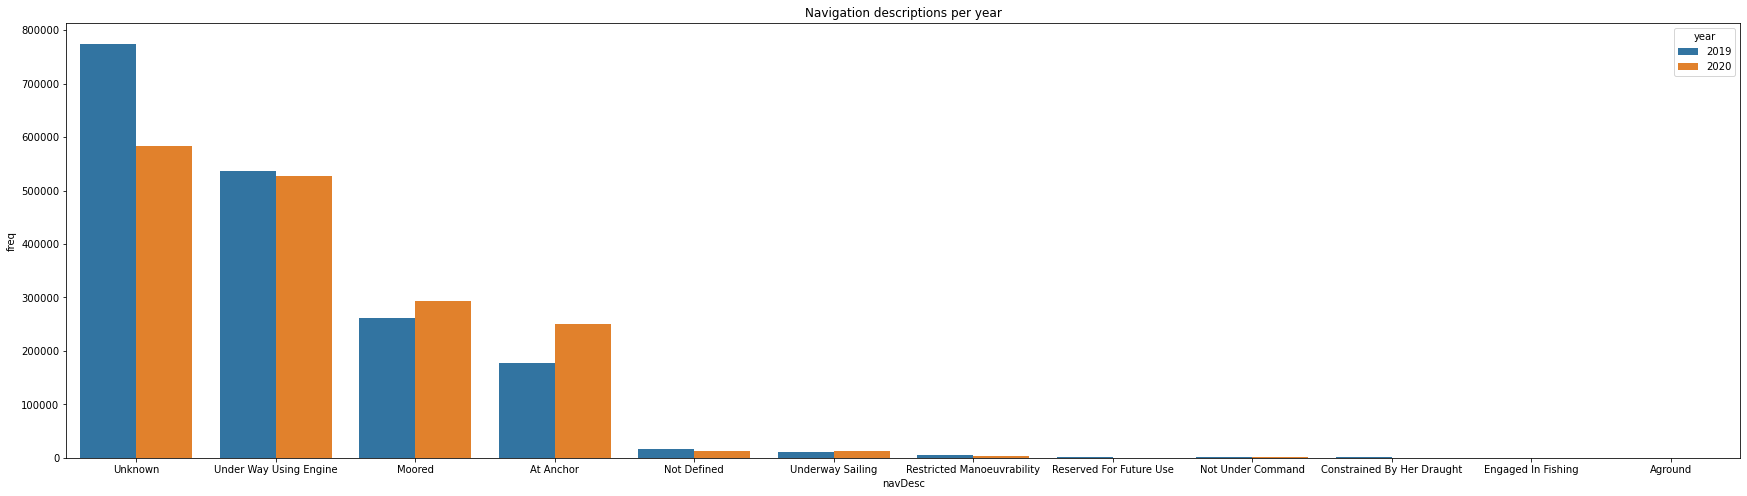

In [63]:
fig = plt.subplots(figsize = (30, 8))
plt.title("Navigation descriptions per year")
sns.barplot(x='navDesc', y='freq', data=df_navdesc, hue='year')

In [64]:
df_dwell = df_sorted[(df_sorted['navDesc']=='At Anchor') | (df_sorted['navDesc']=='Moored')]

In [65]:
len(df_dwell)

980566

In [66]:
columns = list(df_dwell.columns)
columns.remove('year')
columns.remove('navDesc')
columns.remove('navCode')
columns.remove('mmsi')
columns.remove('epochMillis')
df_dwell.drop(columns=columns, inplace=True)
df_dwell

/home/pedro/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,epochMillis,mmsi,navCode,navDesc,year
2390,1553493207000,201804190,5,Moored,2019
2391,1553493926000,201804190,5,Moored,2019
2392,1553499506000,201804190,5,Moored,2019
2393,1553558911000,201804190,5,Moored,2019
2394,1553562013000,201804190,5,Moored,2019
...,...,...,...,...,...
3473666,1585348662000,671885000,5,Moored,2020
3473667,1585350102000,671885000,5,Moored,2020
3473668,1585351182000,671885000,5,Moored,2020
3473669,1585352262000,671885000,5,Moored,2020


In [67]:
df_dwell2019 = df_dwell[df_dwell['year']==2019]
df_dwell2020 = df_dwell[df_dwell['year']==2020]

In [68]:
unique_mmsi = list(df_dwell2019['mmsi'].unique())
unique_mmsi

[201804190,
 205717000,
 209251000,
 209366000,
 209370000,
 209444000,
 209539000,
 209540000,
 209782000,
 209995000,
 210516000,
 210567000,
 212289000,
 212350000,
 212919000,
 212962000,
 215133000,
 215140000,
 215148000,
 215350000,
 218819000,
 218834000,
 219019365,
 219021000,
 219558000,
 219630000,
 219851000,
 219902000,
 219973000,
 220503000,
 220593000,
 220597000,
 220598000,
 220641000,
 224991000,
 228032900,
 228345800,
 229557000,
 229574000,
 229648000,
 229657000,
 229922000,
 232007479,
 232008054,
 232012567,
 232018901,
 232019873,
 232032000,
 235050802,
 235060018,
 235066053,
 235067192,
 235067873,
 235068051,
 235075311,
 235093619,
 235102681,
 235108381,
 235110641,
 235111639,
 236111885,
 236594000,
 238293000,
 238309000,
 240704000,
 241031000,
 241274000,
 241275000,
 241299000,
 241313000,
 241358000,
 241386000,
 241626000,
 246768000,
 247273200,
 247283500,
 247299100,
 248092000,
 248140000,
 248166000,
 248171000,
 248251000,
 248262000,
 248

In [69]:
new_analysis = list()

for mmsi in unique_mmsi:
    df_study = df_dwell2019[df_dwell2019['mmsi']==mmsi]
    for navCode in df_study['navCode'].unique():
        new_dict = dict()
        min_epoch = df_study[df_study['navCode']==navCode]['epochMillis'].min()
        max_epoch = df_study[df_study['navCode']==navCode]['epochMillis'].max()
        lead_time = max_epoch - min_epoch
        new_dict['mmsi'] = mmsi
        new_dict['year'] = 2019
        new_dict['navCode'] = navCode
        new_dict['lead_time'] = lead_time
        new_analysis.append(new_dict)

In [70]:
df_dwell2019 = pd.DataFrame(new_analysis)
df_dwell2019

,mmsi,year,navCode,lead_time
0,201804190,2019,5,338558000
1,205717000,2019,1,11880000
2,205717000,2019,5,224507000
3,209251000,2019,1,44790000
4,209251000,2019,5,43199000
...,...,...,...,...
4146,671728000,2019,1,594612000
4147,671759000,2019,5,461248000
4148,671759000,2019,1,93737000
4149,671815000,2019,1,11160000


In [71]:
unique_mmsi = list(df_dwell2020['mmsi'].unique())
unique_mmsi

[205791000,
 205792000,
 209083000,
 209087000,
 209116000,
 209282000,
 209287000,
 209384000,
 209596000,
 209906000,
 210516000,
 211433000,
 211578000,
 211698000,
 212232000,
 212287000,
 212352000,
 212531000,
 212665000,
 212841000,
 212954000,
 212962000,
 215127000,
 215131000,
 215154000,
 215165000,
 215183000,
 215251000,
 215331000,
 215346000,
 215558000,
 215646000,
 218427000,
 218629000,
 218819000,
 219018271,
 219018986,
 219021000,
 219259000,
 219356000,
 219578000,
 219630000,
 219802000,
 220010000,
 220496000,
 220595000,
 228337900,
 228386700,
 229452000,
 229488000,
 229533000,
 229604000,
 229626000,
 229639000,
 229853000,
 229854000,
 229929000,
 229930000,
 229937000,
 229985000,
 232008054,
 232009365,
 232018919,
 235009240,
 235009850,
 235010450,
 235068029,
 235093797,
 235098383,
 235102678,
 235102679,
 238145000,
 238309000,
 240048000,
 240503000,
 241197000,
 241312000,
 241313000,
 241392000,
 241431000,
 244022000,
 246122000,
 246302000,
 246

In [72]:
new_analysis = list()

for mmsi in unique_mmsi:
    df_study = df_dwell2020[df_dwell2020['mmsi']==mmsi]
    for navCode in df_study['navCode'].unique():
        new_dict = dict()
        min_epoch = df_study[df_study['navCode']==navCode]['epochMillis'].min()
        max_epoch = df_study[df_study['navCode']==navCode]['epochMillis'].max()
        lead_time = max_epoch - min_epoch
        new_dict['mmsi'] = mmsi
        new_dict['year'] = 2020
        new_dict['navCode'] = navCode
        new_dict['lead_time'] = lead_time
        new_analysis.append(new_dict)

In [73]:
df_dwell2020 = pd.DataFrame(new_analysis)
df_dwell2020

,mmsi,year,navCode,lead_time
0,205791000,2020,1,140944000
1,205791000,2020,5,50302000
2,205792000,2020,5,158923000
3,205792000,2020,1,48600000
4,209083000,2020,1,65160000
...,...,...,...,...
4542,671038100,2020,5,0
4543,671059100,2020,5,130892000
4544,671096100,2020,1,268142000
4545,671885000,2020,1,27721000


In [74]:
dwell_time2019 = df_dwell2019['lead_time'].mean()
seconds2019 = dwell_time2019 / 1000.0
minutes2019 = seconds2019/60
hours2019 = minutes2019/60
days2019 = hours2019/24
print(f'2019 mean dwell time is {dwell_time2019} millis, which represents {round(days2019,1)} days')
dwell_time2020 = df_dwell2020['lead_time'].mean()
seconds2020 = dwell_time2020 / 1000.0
minutes2020 = seconds2020/60
hours2020 = minutes2020/60
days2020 = hours2020/24
print(f'2020 mean dwell time is {dwell_time2020} millis, which represents {round(days2020,1)} days')

2019 mean dwell time is 182073247.1693568 millis, which represents 2.1 days
2020 mean dwell time is 203677937.98108643 millis, which represents 2.4 days


In [106]:
print(f'This represents a capacity of {30//days2019} vessels per month in 2019, if the port only had 1 slot available')
print(f'This represents a capacity of {30//days2020} vessels per month in 2020, if the port only had 1 slot available')

slots = 150
print(f'If we consider {slots} port slots, the total vessels per month would be {int((30//days2019)*slots)} in 2019')
print(f'If we consider {slots} port slots, the total vessels per month would be {int((30//days2020)*slots)} in 2020')

This represents a capacity of 14.0 vessels per month in 2019, if the port only had 1 slot available
This represents a capacity of 12.0 vessels per month in 2020, if the port only had 1 slot available
If we consider 150 port slots, the total vessels per month would be 2100 in 2019
If we consider 150 port slots, the total vessels per month would be 1800 in 2020


In [75]:
percentage = (days2020-days2019)/days2019
print(f'This means an increase of {round(percentage*100,1)} % average dwell time compared to 2019')

This means an increase of 11.9 % average dwell time compared to 2019


In [76]:
df_dwell = df_sorted[(df_sorted['navDesc']=='At Anchor') | (df_sorted['navDesc']=='Moored')]
df_dwell

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,date,vessel_latitude,vessel_longitude,port_latitude,port_longitude,navCode,navDesc,speedOverGround,courseOverGround,year
2390,1553493207000,201804190,"{'latitude': 30.179184, 'longitude': 121.9818}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,None,...,2019-03-25,30.179184,121.98180,31.334994,121.659069,5,Moored,0.0,117.6,2019
2391,1553493926000,201804190,"{'latitude': 30.17919, 'longitude': 121.98177}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,None,...,2019-03-25,30.179190,121.98177,31.334994,121.659069,5,Moored,0.0,76.1,2019
2392,1553499506000,201804190,"{'latitude': 30.179213, 'longitude': 121.9818}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,None,...,2019-03-25,30.179213,121.98180,31.334994,121.659069,5,Moored,0.0,68.7,2019
2393,1553558911000,201804190,"{'latitude': 30.179403, 'longitude': 121.98197}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,None,...,2019-03-25,30.179403,121.98197,31.334994,121.659069,5,Moored,0.0,143.3,2019
2394,1553562013000,201804190,"{'latitude': 30.18147, 'longitude': 121.98613}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'A', 'typeName': 'Unknown', 'typeCode...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,None,...,2019-03-25,30.181470,121.98613,31.334994,121.659069,5,Moored,4.9,36.6,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473666,1585348662000,671885000,"{'latitude': 31.362383, 'longitude': 121.49805}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,2020-03-27,31.362383,121.49805,31.334994,121.659069,5,Moored,0.1,260.9,2020
3473667,1585350102000,671885000,"{'latitude': 31.362417, 'longitude': 121.49807}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,2020-03-27,31.362417,121.49807,31.334994,121.659069,5,Moored,0.0,278.7,2020
3473668,1585351182000,671885000,"{'latitude': 31.362383, 'longitude': 121.49803}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,2020-03-27,31.362383,121.49803,31.334994,121.659069,5,Moored,0.0,304.6,2020
3473669,1585352262000,671885000,"{'latitude': 31.362432, 'longitude': 121.49803}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,2020-03-27,31.362432,121.49803,31.334994,121.659069,5,Moored,0.1,290.4,2020


In [77]:
df_dwell['vesselType'] = df_dwell['vesselDetails'].apply(lambda x: x['typeName'])
df_dwell['vesselArea'] = df_dwell['vesselDetails'].apply(lambda x: x['length']*x['width'])


/tmp/ipykernel_2843174/2093882638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dwell['vesselType'] = df_dwell['vesselDetails'].apply(lambda x: x['typeName'])
/tmp/ipykernel_2843174/2093882638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dwell['vesselArea'] = df_dwell['vesselDetails'].apply(lambda x: x['length']*x['width'])


In [78]:
df_dwell['vesselType'].value_counts()
# remove Unknown and Not Available

Cargo                                   576526
Tanker                                  146795
Passenger                                67489
Tug                                      63356
Other                                    31728
Unknown                                  23689
Dredging                                 23405
Law Enforcement                          13622
SAR                                       7204
HSC                                       6611
Pilot                                     5380
Towing                                    4606
Port Tender                               2476
Fishing                                   2040
Vessel With Anti-Pollution Equipment      1411
Pleasure Craft                            1367
Spare                                      971
Diving                                     744
Reserved                                   548
WIG                                        286
Military                                   259
Sailing      

In [79]:
df_dwell['vesselArea'].value_counts()

6080.0     24353
360.0      23789
7200.0     15291
0.0        14735
13140.0    11736
           ...  
3268.0         1
1960.0         1
8904.0         1
1302.0         1
132.0          1
Name: vesselArea, Length: 1185, dtype: int64

In [80]:
len(df_dwell)

980566

In [81]:
df_dwell = df_dwell[df_dwell['vesselType']!='Not Available']
df_dwell = df_dwell[df_dwell['vesselType']!='Unknown']
df_dwell = df_dwell[df_dwell['vesselArea']!=0]
len(df_dwell)

944203

In [82]:
# df_dwell = df_dwell[df_dwell['vesselType'].notna()]
len(df_dwell[df_dwell['vesselType'].notna()])

944203

In [83]:
df_dwell

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,...,vessel_longitude,port_latitude,port_longitude,navCode,navDesc,speedOverGround,courseOverGround,year,vesselType,vesselArea
3131,1553649211000,205717000,"{'latitude': 31.824017, 'longitude': 122.24991}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'LA TONDA', 'typeName': 'Cargo', 'typ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9748485.0,ONIY,CN LUS,...,122.24991,31.334994,121.659069,1,At Anchor,0.1,104.1,2019,Cargo,6368.0
3132,1553649931000,205717000,"{'latitude': 31.824047, 'longitude': 122.24996}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'LA TONDA', 'typeName': 'Cargo', 'typ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9748485.0,ONIY,CN LUS,...,122.24996,31.334994,121.659069,1,At Anchor,0.0,33.6,2019,Cargo,6368.0
3133,1553650651000,205717000,"{'latitude': 31.824064, 'longitude': 122.24985}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'LA TONDA', 'typeName': 'Cargo', 'typ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9748485.0,ONIY,CN LUS,...,122.24985,31.334994,121.659069,1,At Anchor,0.0,33.6,2019,Cargo,6368.0
3134,1553651731000,205717000,"{'latitude': 31.824152, 'longitude': 122.24984}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'LA TONDA', 'typeName': 'Cargo', 'typ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9748485.0,ONIY,CN LUS,...,122.24984,31.334994,121.659069,1,At Anchor,0.1,38.8,2019,Cargo,6368.0
3135,1553652811000,205717000,"{'latitude': 31.824589, 'longitude': 122.2497}","{'navCode': 1, 'navDesc': 'At Anchor', 'course...",Asia/Shanghai,"{'name': 'LA TONDA', 'typeName': 'Cargo', 'typ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9748485.0,ONIY,CN LUS,...,122.24970,31.334994,121.659069,1,At Anchor,0.1,15.7,2019,Cargo,6368.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473666,1585348662000,671885000,"{'latitude': 31.362383, 'longitude': 121.49805}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,121.49805,31.334994,121.659069,5,Moored,0.1,260.9,2020,Cargo,900.0
3473667,1585350102000,671885000,"{'latitude': 31.362417, 'longitude': 121.49807}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,121.49807,31.334994,121.659069,5,Moored,0.0,278.7,2020,Cargo,900.0
3473668,1585351182000,671885000,"{'latitude': 31.362383, 'longitude': 121.49803}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,121.49803,31.334994,121.659069,5,Moored,0.0,304.6,2020,Cargo,900.0
3473669,1585352262000,671885000,"{'latitude': 31.362432, 'longitude': 121.49803}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SKY HARMONY', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",9140190.0,5VEV7,CN ZJG,...,121.49803,31.334994,121.659069,5,Moored,0.1,290.4,2020,Cargo,900.0


In [84]:
new_analysis = list()

for mmsi in unique_mmsi:
    df_study = df_dwell[df_dwell['mmsi']==mmsi]
    for year in df_study['year'].unique():
        for navCode in df_study['navCode'].unique():
            new_dict = dict()
            min_epoch = df_study[(df_study['navCode']==navCode) & (df_study['year']==year)]['epochMillis'].min()
            max_epoch = df_study[(df_study['navCode']==navCode) & (df_study['year']==year)]['epochMillis'].max()
            lead_time = max_epoch - min_epoch
            new_dict['mmsi'] = mmsi
            # print(f"{df_study[(df_study['navCode']==navCode) & (df_study['year']==year)]['vesselType'].unique()} --> {df_study[(df_study['navCode']==navCode) & (df_study['year']==year)]['vesselArea'].unique()}")
            try:
                new_dict['vesselType'] = df_study[(df_study['navCode']==navCode) & (df_study['year']==year)]['vesselType'].unique()[0]
            except:
                new_dict['vesselType'] = '-'
            try:
                new_dict['vesselArea'] = df_study[(df_study['navCode']==navCode) & (df_study['year']==year)]['vesselArea'].unique()[0]
            except:
                new_dict['vesselArea'] = '-'
            new_dict['navCode'] = navCode
            new_dict['lead_time'] = lead_time
            new_dict['year'] = year
            new_analysis.append(new_dict)

In [85]:
df_model = pd.DataFrame(new_analysis)
df_model

,mmsi,vesselType,vesselArea,navCode,lead_time,year
0,205791000,Cargo,8384.0,1,140944000.0,2020
1,205791000,Cargo,8384.0,5,50302000.0,2020
2,205792000,Cargo,8877.0,5,158923000.0,2020
3,205792000,Cargo,8877.0,1,48600000.0,2020
4,209083000,Cargo,5626.0,1,65160000.0,2020
...,...,...,...,...,...,...
6500,671038100,Cargo,1700.0,5,0.0,2020
6501,671059100,Cargo,1776.0,5,130892000.0,2020
6502,671096100,Cargo,2260.0,1,268142000.0,2020
6503,671885000,Cargo,900.0,1,27721000.0,2020


In [86]:
df_model = df_model[df_model['vesselType']!='-']
df_model = df_model[df_model['vesselArea']!='-']
df_model = df_model[df_model['lead_time']!=0]
df_model

,mmsi,vesselType,vesselArea,navCode,lead_time,year
0,205791000,Cargo,8384.0,1,140944000.0,2020
1,205791000,Cargo,8384.0,5,50302000.0,2020
2,205792000,Cargo,8877.0,5,158923000.0,2020
3,205792000,Cargo,8877.0,1,48600000.0,2020
4,209083000,Cargo,5626.0,1,65160000.0,2020
...,...,...,...,...,...,...
6499,667001743,Cargo,1157.0,1,329699000.0,2020
6501,671059100,Cargo,1776.0,5,130892000.0,2020
6502,671096100,Cargo,2260.0,1,268142000.0,2020
6503,671885000,Cargo,900.0,1,27721000.0,2020


In [87]:
df_model.drop(columns=['mmsi','navCode'], inplace=True)

In [88]:
df_model

,vesselType,vesselArea,lead_time,year
0,Cargo,8384.0,140944000.0,2020
1,Cargo,8384.0,50302000.0,2020
2,Cargo,8877.0,158923000.0,2020
3,Cargo,8877.0,48600000.0,2020
4,Cargo,5626.0,65160000.0,2020
...,...,...,...,...
6499,Cargo,1157.0,329699000.0,2020
6501,Cargo,1776.0,130892000.0,2020
6502,Cargo,2260.0,268142000.0,2020
6503,Cargo,900.0,27721000.0,2020


In [89]:
vesselType_conversion = dict()
counter = 0
for item in list(df_model['vesselType'].unique()):
    vesselType_conversion[item] = counter
    counter+=1

In [90]:
vesselType_conversion

{'Cargo': 0,
 'Tanker': 1,
 'Passenger': 2,
 'Other': 3,
 'Dredging': 4,
 'SAR': 5,
 'Tug': 6,
 'Law Enforcement': 7,
 'Pilot': 8,
 'Sailing': 9,
 'Towing': 10,
 'Fishing': 11,
 'HSC': 12,
 'Vessel With Anti-Pollution Equipment': 13,
 'Port Tender': 14,
 'Diving': 15,
 'WIG': 16,
 'Ships Not Party to Armed Conflict': 17,
 'Reserved': 18,
 'Spare': 19}

In [91]:
df_model['vesselTypeClassification'] = df_model['vesselType'].apply(lambda x: vesselType_conversion.get(x))

In [92]:
df_model

,vesselType,vesselArea,lead_time,year,vesselTypeClassification
0,Cargo,8384.0,140944000.0,2020,0
1,Cargo,8384.0,50302000.0,2020,0
2,Cargo,8877.0,158923000.0,2020,0
3,Cargo,8877.0,48600000.0,2020,0
4,Cargo,5626.0,65160000.0,2020,0
...,...,...,...,...,...
6499,Cargo,1157.0,329699000.0,2020,0
6501,Cargo,1776.0,130892000.0,2020,0
6502,Cargo,2260.0,268142000.0,2020,0
6503,Cargo,900.0,27721000.0,2020,0


In [93]:
df_model.drop(columns=['vesselType'], inplace=True)
df_model.reset_index(drop=True, inplace=True)
df_model

,vesselArea,lead_time,year,vesselTypeClassification
0,8384.0,140944000.0,2020,0
1,8384.0,50302000.0,2020,0
2,8877.0,158923000.0,2020,0
3,8877.0,48600000.0,2020,0
4,5626.0,65160000.0,2020,0
...,...,...,...,...
5770,1157.0,329699000.0,2020,0
5771,1776.0,130892000.0,2020,0
5772,2260.0,268142000.0,2020,0
5773,900.0,27721000.0,2020,0


In [94]:
X = df_model.drop(columns=['lead_time'])
y = df_model['lead_time'].to_list()

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [96]:
model = catboost.CatBoostRegressor()
model.fit(X_train, y_train)

Learning rate set to 0.051252
0:	learn: 204347284.4056565	total: 48.2ms	remaining: 48.2s
1:	learn: 202367729.1088057	total: 50.9ms	remaining: 25.4s
2:	learn: 200535292.2718281	total: 54ms	remaining: 17.9s
3:	learn: 198864444.8577479	total: 56.6ms	remaining: 14.1s
4:	learn: 197292970.8390900	total: 60ms	remaining: 11.9s
5:	learn: 195935214.5216912	total: 62.4ms	remaining: 10.3s
6:	learn: 194656132.4316057	total: 64.8ms	remaining: 9.19s
7:	learn: 193495470.3086936	total: 67.4ms	remaining: 8.36s
8:	learn: 192405693.3713305	total: 70ms	remaining: 7.71s
9:	learn: 191450141.9021823	total: 72.1ms	remaining: 7.14s
10:	learn: 190564353.2397054	total: 74.7ms	remaining: 6.71s
11:	learn: 189735651.8882774	total: 77.1ms	remaining: 6.35s
12:	learn: 189129537.0643392	total: 78.3ms	remaining: 5.95s
13:	learn: 188375704.3799881	total: 80.3ms	remaining: 5.66s
14:	learn: 187720202.2364735	total: 82ms	remaining: 5.38s
15:	learn: 187131378.8986685	total: 83.6ms	remaining: 5.14s
16:	learn: 186642028.8067620

In [97]:
y_pred = model.predict(X_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

Testing performance
RMSE: 185795211.3286745
R2: 0.22074095422458273
